In [1]:
# Shape of the inputs of the deep network.
images_shape = (256, 256, 1)

# Variables defining the path to the dataset.
train_input_path = '../Dataset/train/input/'
train_output_path = '../Dataset/train/output/'
val_input_path = '../Dataset/validation/input/'
val_output_path = '../Dataset/validation/output/'
test_input_path = '../Dataset/test/input/'
test_output_path = '../Dataset/test/output/'

# Variable defining where models will be stored.
model_original_save_path = "../Model Original/"
model_retrained_save_path = "../Model Retrained/"

In [2]:
from utils import get_dataset_from_folders

train_images, train_masks = get_dataset_from_folders(train_input_path, train_output_path, images_shape)
val_images, val_masks = get_dataset_from_folders(val_input_path, val_output_path, images_shape)
test_images, test_masks = get_dataset_from_folders(test_input_path, test_output_path, images_shape)

print(f'Training set contains {len(train_images)} images.')
print(f'Validation set contains {len(val_images)} images.')
print(f'Test set contains {len(test_images)} images.')

Training set contains 606 images.
Validation set contains 96 images.
Test set contains 510 images.


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import model

In [4]:
# Building Unet model.
unet = model.unet(images_shape)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
# Setting up parameters used for training
number_epochs = 100
batch_size = 2
early_stopping = EarlyStopping(patience=50, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_original_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Training
history = unet.fit(train_images, train_masks, validation_data = (val_images, val_masks), batch_size = batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

Train on 606 samples, validate on 96 samples
Epoch 1/100
602/606 [============================>.] - ETA: 0s - loss: 1.0012 - accuracy: 0.9385WARNING:tensorflow:From C:\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../Model Original/assets
606/606 [==============================] - 24s 39ms/sample - loss: 0.9957 - accuracy: 0.9386 - val_loss: 0.0721 - val_accuracy: 0.9750
Epoch 2/100
606/606 [==============================] - 20s 32ms/sample - loss: 0.0825 - accuracy: 0.9704 - val_loss: 0.0518 - val_accuracy: 0.9801
Epoch 3/100
606/606 [==============================] - 20s 33ms/sample - loss: 0.0590 - accuracy: 0.9768 - val_loss: 0.0475 - val_accuracy: 0.9821
Epoch 4/100
606/

606/606 [==============================] - 16s 27ms/sample - loss: 0.0205 - accuracy: 0.9914 - val_loss: 0.0464 - val_accuracy: 0.9848
Epoch 40/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0200 - accuracy: 0.9916 - val_loss: 0.0514 - val_accuracy: 0.9844
Epoch 41/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0193 - accuracy: 0.9919 - val_loss: 0.0489 - val_accuracy: 0.9855
Epoch 42/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0197 - accuracy: 0.9917 - val_loss: 0.0471 - val_accuracy: 0.9850
Epoch 43/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0197 - accuracy: 0.9917 - val_loss: 0.0494 - val_accuracy: 0.9855
Epoch 44/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0197 - accuracy: 0.9917 - val_loss: 0.0474 - val_accuracy: 0.9851
Epoch 45/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0193 - accuracy: 0.9919 - val_loss: 0.0461 

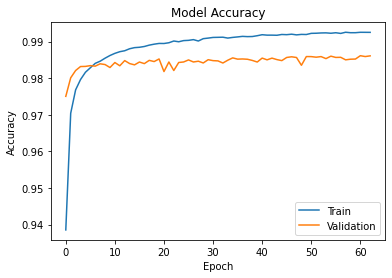

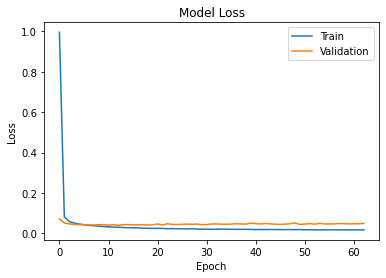

In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
plot_history(history)

In [7]:
unet.evaluate(test_images, test_masks);

510/510 [==============================] - 6s 12ms/sample - loss: 0.0288 - accuracy: 0.9889


In [8]:
from distortions import add_gaussian, add_gaussian_noise

def apply_random_distortion_to_all(function, images, params_for_images={}):
    distorted_images = []

    for image in images:
        params_for_image = {}
        for param, val_range in params_for_images.items():
            params_for_image[param] =  np.random.uniform(*val_range)
            
        distorted_images.append(function(image, **params_for_image))
    
    return np.array(distorted_images)

train_images_added_gaussian = apply_random_distortion_to_all(add_gaussian, train_images, {"amplitude": (0, 500)})
val_images_added_gaussian   = apply_random_distortion_to_all(add_gaussian, val_images  , {"amplitude": (0, 500)})
test_images_added_gaussian  = apply_random_distortion_to_all(add_gaussian, test_images , {"amplitude": (0, 500)})
train_images_added_gaussian_noise = apply_random_distortion_to_all(add_gaussian_noise, train_images, {"mean": (0, 0), "sigma": (0, 50)})
val_images_added_gaussian_noise   = apply_random_distortion_to_all(add_gaussian_noise, val_images  , {"mean": (0, 0), "sigma": (0, 50)})
test_images_added_gaussian_noise  = apply_random_distortion_to_all(add_gaussian_noise, test_images , {"mean": (0, 0), "sigma": (0, 50)})

In [9]:
train_images = np.append(train_images, train_images_added_gaussian      , axis=0)
train_images = np.append(train_images, train_images_added_gaussian_noise, axis=0)
train_masks  = np.repeat(train_masks , 3                                , axis=0)
val_images   = np.append(val_images  , val_images_added_gaussian        , axis=0)
val_images   = np.append(val_images  , val_images_added_gaussian_noise  , axis=0)
val_masks    = np.repeat(val_masks   , 3                                , axis=0)
test_images  = np.append(test_images , test_images_added_gaussian       , axis=0)
test_images  = np.append(test_images , test_images_added_gaussian_noise , axis=0)
test_masks   = np.repeat(test_masks  , 3                                , axis=0)

print(f'Training set contains {len(train_images)} images.')
print(f'Validation set contains {len(val_images)} images.')
print(f'Test set contains {len(test_images)} images.')

Training set contains 1818 images.
Validation set contains 288 images.
Test set contains 1530 images.


In [10]:
# Building Unet model.
unet = model.unet(images_shape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_15[0][0]                  
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 256, 256, 16) 0           conv2d_16[0][0]                  
____________________________________________________________________________________________

In [11]:
# Setting up parameters used for training
number_epochs = 100
batch_size = 2
early_stopping = EarlyStopping(patience=50, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_retrained_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Training
history = unet.fit(train_images, train_masks, validation_data = (val_images, val_masks), batch_size = batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

Train on 1818 samples, validate on 288 samples
Epoch 1/100
1818/1818 [==============================] - 53s 29ms/sample - loss: 0.5974 - accuracy: 0.9038 - val_loss: 0.3112 - val_accuracy: 0.9067
Epoch 2/100
1818/1818 [==============================] - 51s 28ms/sample - loss: 0.3051 - accuracy: 0.9109 - val_loss: 0.3145 - val_accuracy: 0.9067
Epoch 3/100
1818/1818 [==============================] - 47s 26ms/sample - loss: 0.3038 - accuracy: 0.9109 - val_loss: 0.3113 - val_accuracy: 0.9067037 - 
Epoch 4/100
1818/1818 [==============================] - 48s 26ms/sample - loss: 0.3035 - accuracy: 0.9109 - val_loss: 0.3108 - val_accuracy: 0.9067
Epoch 5/100
1818/1818 [==============================] - 47s 26ms/sample - loss: 0.3035 - accuracy: 0.9109 - val_loss: 0.3102 - val_accuracy: 0.9067
Epoch 6/100
1818/1818 [==============================] - 48s 26ms/sample - loss: 0.3033 - accuracy: 0.9109 - val_loss: 0.3105 - val_accuracy: 0.9067
Epoch 7/100
1818/1818 [==============================

1818/1818 [==============================] - 47s 26ms/sample - loss: 0.3007 - accuracy: 0.9109 - val_loss: 0.3102 - val_accuracy: 0.9067
Epoch 53/100
1818/1818 [==============================] - 47s 26ms/sample - loss: 0.3007 - accuracy: 0.9109 - val_loss: 0.3104 - val_accuracy: 0.9067
Epoch 54/100
1818/1818 [==============================] - 47s 26ms/sample - loss: 0.3007 - accuracy: 0.9109 - val_loss: 0.3102 - val_accuracy: 0.9067
Epoch 55/100
1818/1818 [==============================] - 48s 26ms/sample - loss: 0.3007 - accuracy: 0.9109 - val_loss: 0.3104 - val_accuracy: 0.9067
Epoch 56/100
1818/1818 [==============================] - 48s 26ms/sample - loss: 0.3007 - accuracy: 0.9109 - val_loss: 0.3102 - val_accuracy: 0.9067
Epoch 57/100
1818/1818 [==============================] - 47s 26ms/sample - loss: 0.3007 - accuracy: 0.9109 - val_loss: 0.3105 - val_accuracy: 0.9067
Epoch 58/100
1818/1818 [==============================] - 48s 26ms/sample - loss: 0.3006 - accuracy: 0.9109 - val

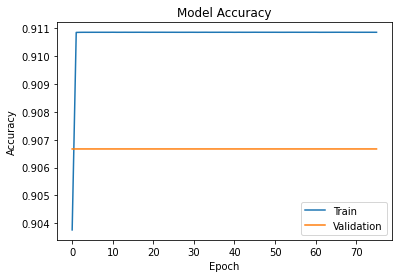

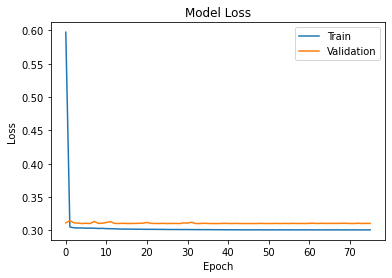

In [12]:
plot_history(history)

In [13]:
unet.evaluate(test_images, test_masks);

1530/1530 [==============================] - 12s 8ms/sample - loss: 0.2531 - accuracy: 0.9317
